In [131]:
# Import dependencies
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [13]:
# Read data
red_zone_line_player_proximity = pd.read_csv('https://storage.googleapis.com/big-data-bowl/redZoneLinePlayerProximity.csv')
red_zone_qb_proximity = pd.read_csv('https://storage.googleapis.com/big-data-bowl/redZoneQBProximity.csv')

In [70]:
# Define matchup threshold
matchup_distance_threshold = 1
matchup_duration_threshold = 20

In [77]:
# Get unique matchups that fall below threshold for frames exceeding the matchup duration_threshold
red_zone_line_player_matchups = red_zone_line_player_proximity[red_zone_line_player_proximity['distance'] <= matchup_distance_threshold]
unique_matchups = red_zone_line_player_matchups[['gameId', 'playId', 'nflId', 'nflId2', 'frameId']].groupby(['gameId', 'playId', 'nflId', 'nflId2']).min().reset_index()

In [106]:
# Initialize confirmed matchups DataFrame
confirmed_matchups = pd.DataFrame()

In [107]:
# Add matchup that last for more frames than matchup_duration_threshold to confirmed matchups DataFrame
for i, r in unique_matchups.iterrows():
    matchup = True
    for f in range(matchup_duration_threshold):
        matchup_frame = red_zone_line_player_matchups[
            (red_zone_line_player_matchups['gameId'] == r['gameId']) & \
            (red_zone_line_player_matchups['playId'] == r['playId']) & \
            (red_zone_line_player_matchups['nflId'] == r['nflId']) & \
            (red_zone_line_player_matchups['nflId2'] == r['nflId2']) & \
            (red_zone_line_player_matchups['frameId'] == r['frameId'] + f)
        ]
        if len(matchup_frame) == 0:
            matchup = False
            break
    if matchup:
        confirmed_matchups = confirmed_matchups.append(r)

In [109]:
# Clean confirmed matchups
confirmed_matchups = confirmed_matchups.rename(columns={'frameId': 'firstFrameId'})
confirmed_matchups['lastFrameId'] = confirmed_matchups['firstFrameId'].apply(lambda x: x + 20)

In [122]:
# Merge defensive player's initial distance to QB
matchup_qb_distance = confirmed_matchups.merge(
    red_zone_qb_proximity,
    left_on=['gameId', 'playId', 'firstFrameId', 'nflId'],
    right_on=['gameId', 'playId', 'frameId', 'nflId2'],
    how='inner',
    suffixes=('', '_qb')
)

In [123]:
# Merge defensive player's initial distance to QB
matchup_qb_distance = matchup_qb_distance.merge(
    red_zone_qb_proximity,
    left_on=['gameId', 'playId', 'lastFrameId', 'nflId'],
    right_on=['gameId', 'playId', 'frameId', 'nflId2'],
    how='inner',
    suffixes=('', '_final')
)

In [128]:
# Find pocket progression across matchup frames
matchup_qb_distance['progression'] = matchup_qb_distance.apply(lambda r: r['distance_final'] - r['distance'], axis=1)

In [133]:
# Drop unused columns
matchup_qb_distance = matchup_qb_distance[['gameId', 'playId', 'nflId', 'nflId2', 'progression']]

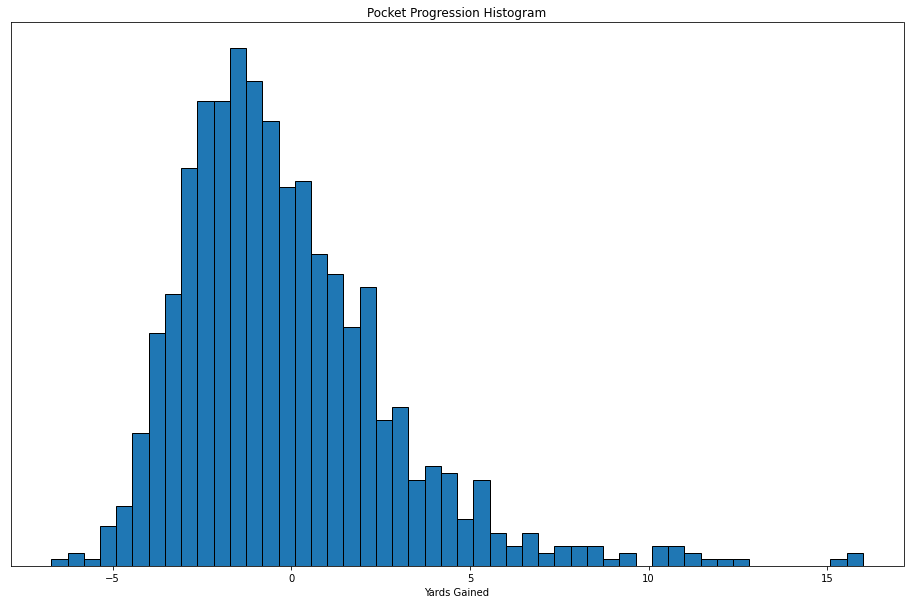

In [151]:
# Plot histogram
plt.figure(figsize=(16, 10))
plt.hist(matchup_qb_distance['progression'], bins=50, edgecolor='black')
plt.yticks([])
plt.xlabel('Yards Gained')
plt.title('Pocket Progression Histogram')
plt.show()

In [ ]:
# Remove outliers

In [ ]:
# Clean for ML model